# Advanced Feature Engineering and Selection

## Overview
This notebook explores advanced feature engineering techniques including:
- Polynomial features
- Interaction features
- Feature selection methods
- Dimensionality reduction
- Feature importance analysis

## Contents
1. Load Processed Data
2. Create Polynomial Features
3. Create Interaction Features
4. Feature Selection (Filter Methods)
5. Feature Selection (Wrapper Methods)
6. Feature Selection (Embedded Methods)
7. Dimensionality Reduction (PCA)
8. Final Feature Set Selection

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    RFE, RFECV, SelectFromModel
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
data = pd.read_csv('output/processed_data.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nFeatures: {data.shape[1]}")
print(f"Samples: {data.shape[0]}")

data.head()

Dataset shape: (2000, 43)

Features: 43
Samples: 2000


,ID,admission_date,admission_time,discharge_date,discharge_time,hospital_ID,gender,age,disease_status,length_of_stay,...,sodium_high,sodium_abnormal,potassium_low,potassium_high,potassium_abnormal,urea_high,chloride_low,chloride_high,bicarbonate_low,bicarbonate_high
0,1003,2002-04-25,07:47,2002-05-08,12:02,St. Joseph's Health Centre,F,59.0,0,13,...,0,1,0,0,0,0,0,0,0,0
1,1008,2004-09-02,07:49,2005-02-01,10:07,St. Michael's Hospital,M,58.0,0,152,...,0,0,0,0,0,0,0,0,0,0
2,1009,2011-01-01,17:08,2011-06-26,08:16,St. Michael's Hospital,M,59.0,1,176,...,1,1,0,0,0,0,0,0,0,0
3,1019,2000-03-09,10:15,2000-05-29,22:38,St. Michael's Hospital,M,59.0,1,81,...,0,0,0,0,0,0,1,0,0,0
4,1030,2003-11-18,08:31,2004-01-28,13:21,St. Michael's Hospital,F,72.0,0,71,...,1,1,0,1,1,0,0,0,0,0


## 2. Prepare Base Features

In [3]:
exclude_columns = ['ID', 'admission_date', 'discharge_date', 'admission_time', 'discharge_time', 'disease_status']
feature_columns = [col for col in data.columns if col not in exclude_columns]

numerical_features = data[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data[feature_columns].select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

X = data[numerical_features].fillna(data[numerical_features].median())
y = data['disease_status']

print(f"\nX shape: {X.shape}")
print(f"y distribution:\n{y.value_counts()}")

Numerical features: 35
Categorical features: 2

X shape: (2000, 35)
y distribution:
disease_status
0    1026
1     974
Name: count, dtype: int64


## 3. Create Polynomial Features

Polynomial features can capture non-linear relationships between variables.

In [4]:
lab_features = ['Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma',
                'Potassium plasma', 'Sodium plasma', 'Urea plasma']

lab_features_available = [f for f in lab_features if f in X.columns]

if lab_features_available:
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    X_lab = X[lab_features_available]
    X_poly = poly.fit_transform(X_lab)
    
    poly_feature_names = poly.get_feature_names_out(lab_features_available)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)
    
    print(f"Original lab features: {len(lab_features_available)}")
    print(f"After polynomial transformation: {X_poly_df.shape[1]}")
    print(f"\nNew polynomial features created: {X_poly_df.shape[1] - len(lab_features_available)}")
    
    print(f"\nExample polynomial features:")
    print(poly_feature_names[:15])
else:
    X_poly_df = pd.DataFrame()
    print("No lab features available for polynomial transformation")

Original lab features: 6
After polynomial transformation: 27

New polynomial features created: 21

Example polynomial features:
['Bicarbonate plasma' 'Chloride plasma' 'Creatinine plasma'
 'Potassium plasma' 'Sodium plasma' 'Urea plasma' 'Bicarbonate plasma^2'
 'Bicarbonate plasma Chloride plasma'
 'Bicarbonate plasma Creatinine plasma'
 'Bicarbonate plasma Potassium plasma' 'Bicarbonate plasma Sodium plasma'
 'Bicarbonate plasma Urea plasma' 'Chloride plasma^2'
 'Chloride plasma Creatinine plasma' 'Chloride plasma Potassium plasma']


## 4. Create Domain-Specific Interaction Features

In [5]:
X_interact = X.copy()

if 'age' in X_interact.columns and 'length_of_stay' in X_interact.columns:
    X_interact['age_los_interaction'] = X_interact['age'] * X_interact['length_of_stay']
    X_interact['age_squared'] = X_interact['age'] ** 2
    X_interact['los_squared'] = X_interact['length_of_stay'] ** 2

if 'Sodium plasma' in X_interact.columns and 'Potassium plasma' in X_interact.columns:
    X_interact['sodium_potassium_ratio'] = X_interact['Sodium plasma'] / (X_interact['Potassium plasma'] + 1e-5)
    X_interact['sodium_potassium_sum'] = X_interact['Sodium plasma'] + X_interact['Potassium plasma']

if 'Creatinine plasma' in X_interact.columns and 'Urea plasma' in X_interact.columns:
    X_interact['creat_urea_ratio'] = X_interact['Creatinine plasma'] / (X_interact['Urea plasma'] + 1e-5)

if 'lab_mean_value' in X_interact.columns and 'lab_std_value' in X_interact.columns:
    X_interact['coefficient_of_variation'] = X_interact['lab_std_value'] / (X_interact['lab_mean_value'] + 1e-5)

interaction_features = [col for col in X_interact.columns if col not in X.columns]

print(f"Created {len(interaction_features)} domain-specific interaction features:")
for feat in interaction_features:
    print(f"  - {feat}")

print(f"\nTotal features now: {X_interact.shape[1]}")

Created 7 domain-specific interaction features:
  - age_los_interaction
  - age_squared
  - los_squared
  - sodium_potassium_ratio
  - sodium_potassium_sum
  - creat_urea_ratio
  - coefficient_of_variation

Total features now: 42


## 5. Filter Methods: Statistical Tests

Top 20 Features by F-Score:
                     Feature   F-Score   P-Value
35       age_los_interaction  4.388971  0.036298
7            Chloride plasma  4.174446  0.041169
36               age_squared  2.813332  0.093640
0                        age  2.768668  0.096283
37               los_squared  2.241040  0.134549
1             length_of_stay  2.095891  0.147853
31              chloride_low  2.069753  0.150403
21             lab_min_value  1.882452  0.170210
22                 lab_range  1.788949  0.181207
13                 is_winter  1.586037  0.208040
17            lab_test_count  1.328739  0.249168
4      admission_day_of_week  1.190415  0.275377
19             lab_std_value  1.138237  0.286154
12      is_weekend_admission  0.988218  0.320299
29        potassium_abnormal  0.981331  0.321990
40          creat_urea_ratio  0.858975  0.354138
41  coefficient_of_variation  0.794889  0.372733
2             admission_year  0.755021  0.384996
11               Urea plasma  0.728254  0

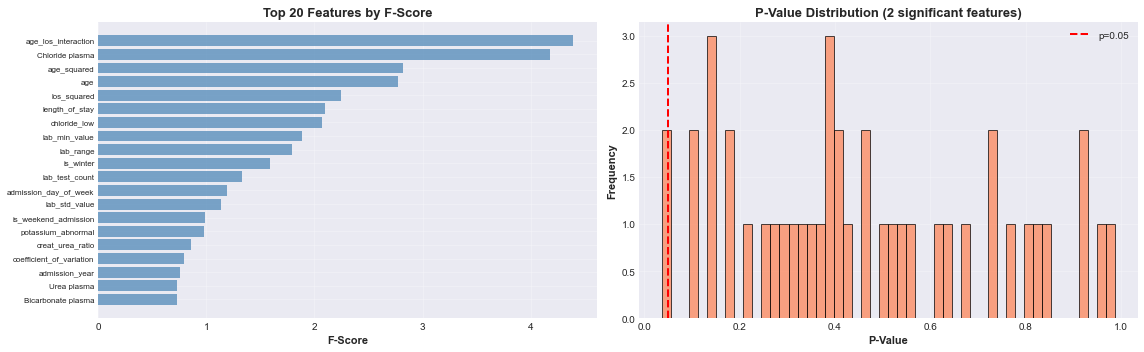


Significant features (p < 0.05): 2


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interact)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_interact.columns)

selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_scaled_df, y)

f_scores = pd.DataFrame({
    'Feature': X_interact.columns,
    'F-Score': selector_f.scores_,
    'P-Value': selector_f.pvalues_
}).sort_values('F-Score', ascending=False)

print("Top 20 Features by F-Score:")
print(f_scores.head(20))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

top_20_f = f_scores.head(20)
axes[0].barh(range(20), top_20_f['F-Score'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_20_f['Feature'], fontsize=8)
axes[0].set_xlabel('F-Score', fontsize=11, fontweight='bold')
axes[0].set_title('Top 20 Features by F-Score', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3)

significant_features = f_scores[f_scores['P-Value'] < 0.05]
axes[1].hist(f_scores['P-Value'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
axes[1].set_xlabel('P-Value', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'P-Value Distribution ({len(significant_features)} significant features)', 
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSignificant features (p < 0.05): {len(significant_features)}")

## 6. Filter Methods: Mutual Information

Top 20 Features by Mutual Information:
                     Feature  MI-Score
20             lab_max_value  0.036567
0                        age  0.022857
36               age_squared  0.020939
41  coefficient_of_variation  0.018767
10             Sodium plasma  0.016762
29        potassium_abnormal  0.015274
38    sodium_potassium_ratio  0.014437
23           creatinine_high  0.014419
11               Urea plasma  0.013753
15                 is_summer  0.013249
18            lab_mean_value  0.012592
37               los_squared  0.012054
25               sodium_high  0.011693
4      admission_day_of_week  0.011096
32             chloride_high  0.010605
3            admission_month  0.009326
9           Potassium plasma  0.007854
5          admission_quarter  0.007736
40          creat_urea_ratio  0.007064
2             admission_year  0.004540


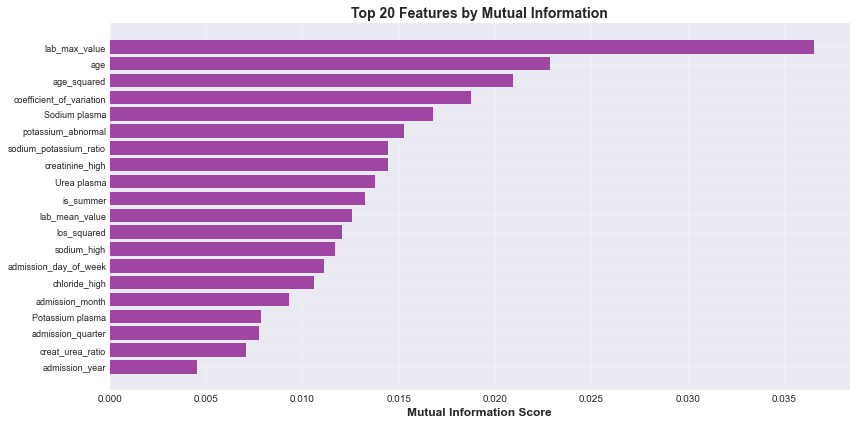

In [7]:
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_scaled_df, y)

mi_scores = pd.DataFrame({
    'Feature': X_interact.columns,
    'MI-Score': selector_mi.scores_
}).sort_values('MI-Score', ascending=False)

print("Top 20 Features by Mutual Information:")
print(mi_scores.head(20))

plt.figure(figsize=(12, 6))
top_20_mi = mi_scores.head(20)
plt.barh(range(20), top_20_mi['MI-Score'], color='purple', alpha=0.7)
plt.yticks(range(20), top_20_mi['Feature'], fontsize=9)
plt.xlabel('Mutual Information Score', fontsize=12, fontweight='bold')
plt.title('Top 20 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Wrapper Methods: Recursive Feature Elimination

Running Recursive Feature Elimination with Cross-Validation...
This may take a few minutes...

Optimal number of features: 28

Selected features by RFECV:
  1. age
  2. length_of_stay
  3. admission_year
  4. admission_month
  5. admission_day_of_week
  6. admission_quarter
  7. Bicarbonate plasma
  8. Chloride plasma
  9. Creatinine plasma
  10. Potassium plasma
  11. Sodium plasma
  12. Urea plasma
  13. is_weekend_admission
  14. is_winter
  15. is_summer
  16. lab_test_count
  17. lab_mean_value
  18. lab_std_value
  19. lab_max_value
  20. lab_min_value
  21. lab_range
  22. age_los_interaction
  23. age_squared
  24. los_squared
  25. sodium_potassium_ratio
  26. sodium_potassium_sum
  27. creat_urea_ratio
  28. coefficient_of_variation


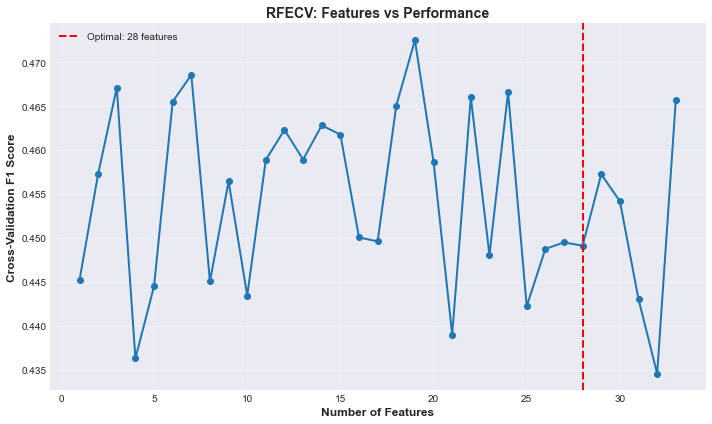

In [8]:
rf_estimator = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)

print("Running Recursive Feature Elimination with Cross-Validation...")
print("This may take a few minutes...\n")

rfecv = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,
    scoring='f1',
    min_features_to_select=10,
    n_jobs=-1
)

rfecv.fit(X_scaled_df, y)

print(f"Optimal number of features: {rfecv.n_features_}")

selected_features_rfe = X_interact.columns[rfecv.support_].tolist()
print(f"\nSelected features by RFECV:")
for i, feat in enumerate(selected_features_rfe, 1):
    print(f"  {i}. {feat}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'],
         marker='o', linewidth=2, markersize=6)
plt.axvline(rfecv.n_features_, color='red', linestyle='--', linewidth=2,
            label=f'Optimal: {rfecv.n_features_} features')
plt.xlabel('Number of Features', fontsize=12, fontweight='bold')
plt.ylabel('Cross-Validation F1 Score', fontsize=12, fontweight='bold')
plt.title('RFECV: Features vs Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Embedded Methods: Tree-Based Feature Importance

Top 20 Features by Random Forest Importance:
                     Feature  Importance
35       age_los_interaction    0.071430
1             length_of_stay    0.062172
37               los_squared    0.060399
36               age_squared    0.052151
41  coefficient_of_variation    0.051992
18            lab_mean_value    0.051466
0                        age    0.051236
2             admission_year    0.050652
21             lab_min_value    0.050532
20             lab_max_value    0.049817
3            admission_month    0.041052
38    sodium_potassium_ratio    0.037698
39      sodium_potassium_sum    0.035987
4      admission_day_of_week    0.035807
10             Sodium plasma    0.028709
40          creat_urea_ratio    0.027817
19             lab_std_value    0.025923
22                 lab_range    0.023984
7            Chloride plasma    0.020154
11               Urea plasma    0.019701


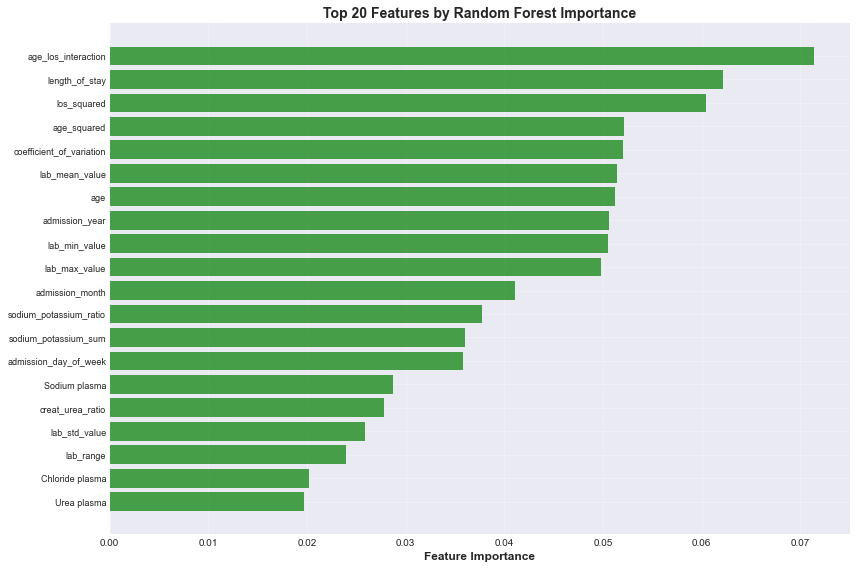


Features with importance > 0.01: 24


In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_scaled_df, y)

feature_importance = pd.DataFrame({
    'Feature': X_interact.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features by Random Forest Importance:")
print(feature_importance.head(20))

plt.figure(figsize=(12, 8))
top_20_imp = feature_importance.head(20)
plt.barh(range(20), top_20_imp['Importance'], color='green', alpha=0.7)
plt.yticks(range(20), top_20_imp['Feature'], fontsize=9)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

importance_threshold = 0.01
important_features = feature_importance[feature_importance['Importance'] > importance_threshold]['Feature'].tolist()
print(f"\nFeatures with importance > {importance_threshold}: {len(important_features)}")

## 9. Dimensionality Reduction: PCA

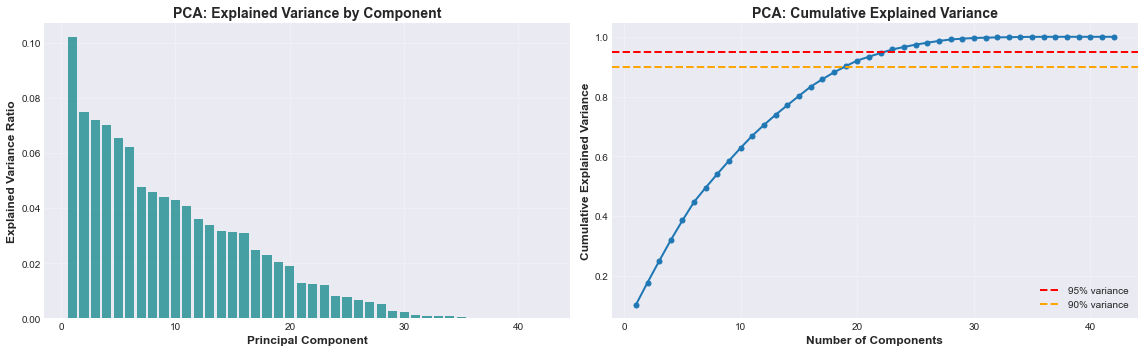

Components needed for 90% variance: 19
Components needed for 95% variance: 23
Total components: 42


In [10]:
pca_full = PCA(random_state=RANDOM_STATE)
X_pca = pca_full.fit_transform(X_scaled_df)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='teal')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('PCA: Explained Variance by Component', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio,
             marker='o', linewidth=2, markersize=5)
axes[1].axhline(0.95, color='red', linestyle='--', linewidth=2, label='95% variance')
axes[1].axhline(0.90, color='orange', linestyle='--', linewidth=2, label='90% variance')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('PCA: Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1

print(f"Components needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")
print(f"Total components: {len(explained_variance_ratio)}")

## 10. Feature Selection Comparison


FEATURE SELECTION METHODS COMPARISON
                     Method  Features Selected
           F-Score (p<0.05)                  2
Mutual Information (top 20)                 20
                      RFECV                 28
      Random Forest (>0.01)                 24
              PCA (95% var)                 23


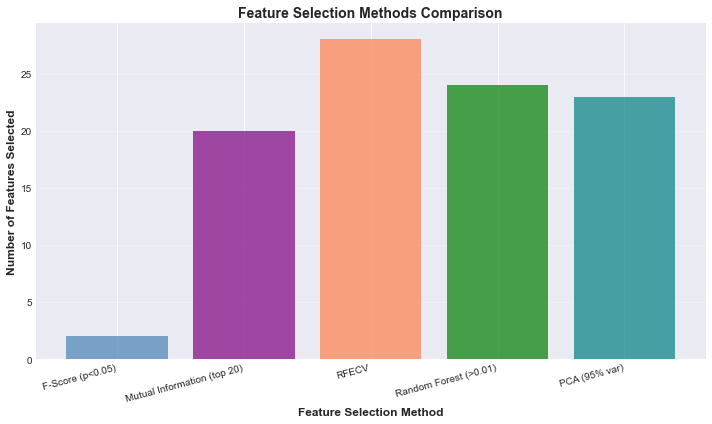

In [11]:
methods_comparison = pd.DataFrame({
    'Method': ['F-Score (p<0.05)', 'Mutual Information (top 20)', 'RFECV', 'Random Forest (>0.01)', 'PCA (95% var)'],
    'Features Selected': [
        len(significant_features),
        20,
        rfecv.n_features_,
        len(important_features),
        n_components_95
    ]
})

print("\n" + "="*80)
print("FEATURE SELECTION METHODS COMPARISON")
print("="*80)
print(methods_comparison.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.bar(methods_comparison['Method'], methods_comparison['Features Selected'], 
        color=['steelblue', 'purple', 'coral', 'green', 'teal'], alpha=0.7)
plt.xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
plt.ylabel('Number of Features Selected', fontsize=12, fontweight='bold')
plt.title('Feature Selection Methods Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 11. Create Final Optimized Feature Set

In [12]:
top_f_features = f_scores.head(15)['Feature'].tolist()
top_mi_features = mi_scores.head(15)['Feature'].tolist()
top_rf_features = feature_importance.head(15)['Feature'].tolist()

consensus_features = list(set(top_f_features + top_mi_features + top_rf_features + selected_features_rfe))

print(f"Consensus feature set size: {len(consensus_features)}")
print(f"\nConsensus features:")
for i, feat in enumerate(sorted(consensus_features), 1):
    print(f"  {i}. {feat}")

X_optimized = X_interact[consensus_features]

import os
os.makedirs('output', exist_ok=True)

X_optimized.to_csv('output/optimized_features.csv', index=False)
pd.DataFrame({'feature': consensus_features}).to_csv('output/selected_features_list.csv', index=False)

print(f"\n✓ Optimized feature set saved to: output/optimized_features.csv")
print(f"✓ Feature list saved to: output/selected_features_list.csv")

Consensus feature set size: 33

Consensus features:
  1. Bicarbonate plasma
  2. Chloride plasma
  3. Creatinine plasma
  4. Potassium plasma
  5. Sodium plasma
  6. Urea plasma
  7. admission_day_of_week
  8. admission_month
  9. admission_quarter
  10. admission_year
  11. age
  12. age_los_interaction
  13. age_squared
  14. chloride_high
  15. chloride_low
  16. coefficient_of_variation
  17. creat_urea_ratio
  18. creatinine_high
  19. is_summer
  20. is_weekend_admission
  21. is_winter
  22. lab_max_value
  23. lab_mean_value
  24. lab_min_value
  25. lab_range
  26. lab_std_value
  27. lab_test_count
  28. length_of_stay
  29. los_squared
  30. potassium_abnormal
  31. sodium_high
  32. sodium_potassium_ratio
  33. sodium_potassium_sum

✓ Optimized feature set saved to: output/optimized_features.csv
✓ Feature list saved to: output/selected_features_list.csv


## 12. Summary

In [13]:
print("="*80)
print("ADVANCED FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\nOriginal features: {len(X.columns)}")
print(f"After interaction features: {len(X_interact.columns)}")
if not X_poly_df.empty:
    print(f"Polynomial features created: {X_poly_df.shape[1]}")
print(f"\nFinal optimized feature set: {len(consensus_features)}")
print(f"Reduction: {len(X_interact.columns) - len(consensus_features)} features removed")
print(f"Compression ratio: {len(consensus_features)/len(X_interact.columns)*100:.1f}%")

print(f"\n{'Feature Selection Results':-^80}")
print(f"  • Statistically significant (p<0.05): {len(significant_features)}")
print(f"  • High mutual information (top 20): 20")
print(f"  • RFECV selected: {rfecv.n_features_}")
print(f"  • Important by Random Forest: {len(important_features)}")
print(f"  • PCA components (95% variance): {n_components_95}")

print(f"\n{'='*80}")
print("Feature engineering complete!")
print("="*80)

ADVANCED FEATURE ENGINEERING SUMMARY

Original features: 35
After interaction features: 42
Polynomial features created: 27

Final optimized feature set: 33
Reduction: 9 features removed
Compression ratio: 78.6%

---------------------------Feature Selection Results----------------------------
  • Statistically significant (p<0.05): 2
  • High mutual information (top 20): 20
  • RFECV selected: 28
  • Important by Random Forest: 24
  • PCA components (95% variance): 23

Feature engineering complete!
